# Принятие решений в бизнесе. Аналитика крупного интернет-магазина

На основании предоставленных отделом маркетинга списка гипотез для увеличения выручки, приоритизируем гипотезы, запустим А/В тест и проанализируем результаты

Описание данных:
1. Данные для первой части  

Файл /datasets/hypothesis.csv  

Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

2. Данные для второй части  

Файл /datasets/orders.csv  

transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv  

date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
try:
    hypothesis = pd.read_csv('C:/Users/mrsag/Desktop/Аналитик буткемп/Проекты/8. Принятие решений в бизнесе/hypothesis.csv')
    orders = pd.read_csv('C:/Users/mrsag/Desktop/Аналитик буткемп/Проекты/8. Принятие решений в бизнесе/orders.csv')
    visitors = pd.read_csv('C:/Users/mrsag/Desktop/Аналитик буткемп/Проекты/8. Принятие решений в бизнесе/visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", 999)

In [4]:
display(hypothesis.head(5),hypothesis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


None

In [5]:
display(orders.head(5),orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


None

In [6]:
display(visitors.head(5),visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


None

In [7]:
display(hypothesis.isna().sum(), orders.isna().sum(), visitors.isna().sum())

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [8]:
hypothesis.duplicated().sum(),orders.duplicated().sum(),visitors.duplicated().sum()

(0, 0, 0)

In [9]:
hypothesis.columns = hypothesis.columns.str.lower()

In [10]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Данные к анализу готовы:
1. Пропусков и дубликатов нет
2. В таблице hypothesis названия колонок переведены в правильный регистр
3. В таблицах orders и visitors даты переведены в правильный формат

In [11]:
doubles = orders.groupby(['visitorId']).agg({'group' : 'nunique', 'transactionId' : 'count', 'revenue' : 'sum'}).reset_index()
print(doubles[doubles.group != 1]["visitorId"].count())

d_list = list(doubles[doubles.group != 1]['visitorId'])
orders_good = orders.query('visitorId not in @d_list')


58


## Часть 1. Приоритизация гипотез

### Применение фреймворка ICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [12]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence']  / hypothesis['efforts']
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Лидер - гипотеза 8

### Применение фреймворка RICE  для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [13]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Лидер - гипотеза 7

### Как изменилась приоритизация гипотез при применении RICE вместо ICE

In [14]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


При применении RICE гипотеза 7 заняла первое место, так как при расчете этого покзателя учитывается количество пользователей, а у этой гипотезы их 10 (наибольшее количество)

## Часть 2. Анализ A/B-теста

In [15]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].\
    agg({'date': 'max',
        'group': 'max',
        'transactionId': 'nunique',
        'visitorId': 'nunique',
        'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].\
    agg({'date': 'max', 
         'group': 'max', 
         'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors']

cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors'])

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']


mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

### График кумулятивной выручки по группам

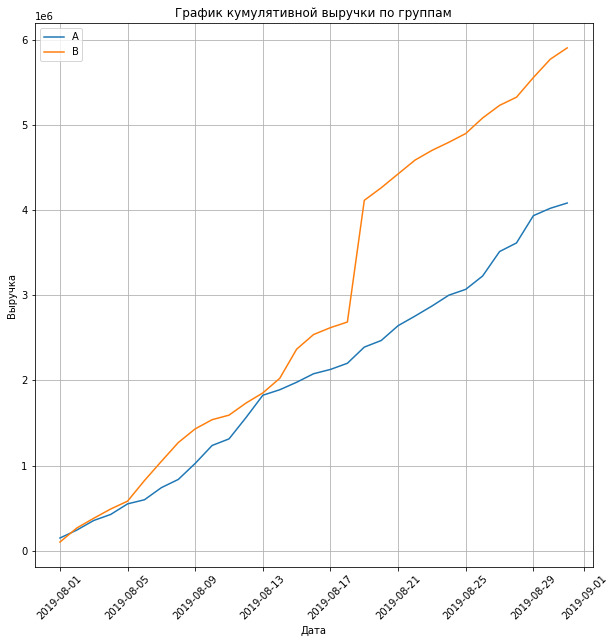

In [16]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.grid()
plt.legend(); 

Наблюдается резкий скачок группы B, причиной может быть как увеличение числа заказов, так и появление дорогих заказов

### График кумулятивного среднего чека по группам

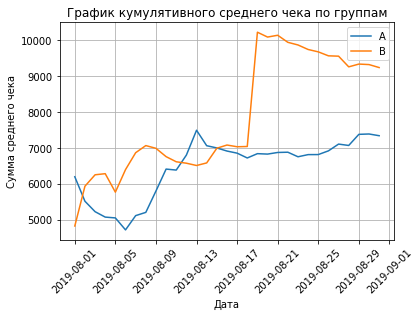

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=45)
plt.grid()
plt.legend();

Аналогичная ситуация, возможно есть выбросы данных(аномальные значения).   
Лидирует группа В, наблюдается резкий рост группы B c 17.08.2019, который совпадает с датой резкого роста выручки. В конце графика наблюдается стабильность, но группа В все также лидирует

###  График относительного изменения кумулятивного среднего чека группы B к группе A

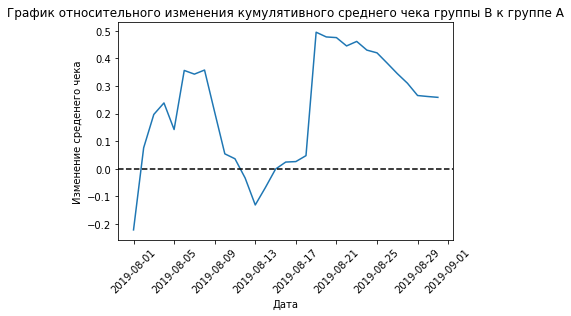

In [18]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение среденего чека')
plt.xticks(rotation=45);


3 графика показывают нам одинаковую картину, наблюдается всплеск ориентировочно 17.08.2019

###   График кумулятивного среднего количества заказов на посетителя по группам

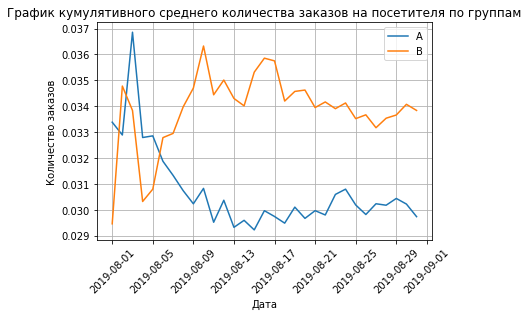

In [19]:
cumulativeData['count_orders'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['count_orders'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['count_orders'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid()
plt.legend();

Группы начали с разных позиций, группа A постепенно просела, а группа B стабилизировалась, выше группы A

###  График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

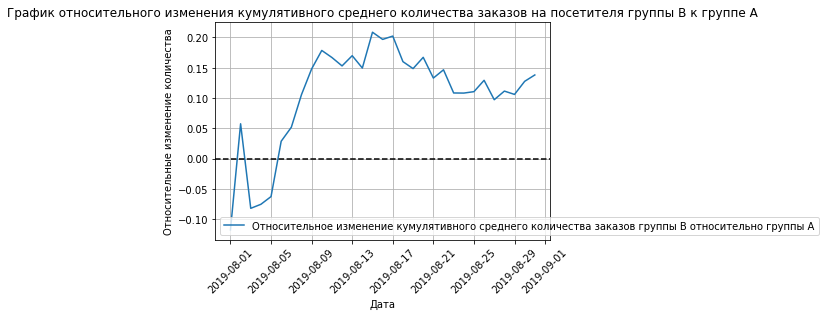

In [20]:
mergedCumulativeСount_orders = cumulativeDataA[['date','count_orders']].merge(cumulativeDataB[['date','count_orders']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeСount_orders['date'], mergedCumulativeСount_orders['count_ordersB']/mergedCumulativeСount_orders['count_ordersA']-1, label="Относительное изменение кумулятивного среднего количества заказов группы B относительно группы A")
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительные изменение количества')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.legend();


Группа В лидирует по значениями среднего количества заказов на посетителя, график закрепился ориентировочно с 21.08.2019

###  Точечный график количества заказов по пользователям

In [21]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'}))

ordersByUsers.columns = ['userId', 'orders']

In [22]:
ordersByUsers

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


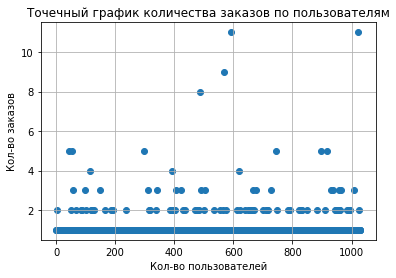

In [23]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.grid()
plt.xlabel('Кол-во пользователей')
plt.ylabel('Кол-во заказов');

Большинство пользователей заказывают 1 раз, меньшее количество 2 раза, 3 и более вероятно - аномальные значения

###  95-й и 99-й перцентили количества заказов на пользователя

In [24]:
print('95 перцентиль: %.2f' % (np.percentile(ordersByUsers['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(ordersByUsers['orders'], [99])))

95 перцентиль: 2.00
99 перцентиль: 4.00


In [25]:
(ordersByUsers.query('orders > 2')['orders'].count()/ordersByUsers['orders'].count())*100

2.909796314258002

Около 3% пользователей оформили больше 2 заказов, можно отсеять как аномальных пользователей с 3 и более заказами

###  Точечный график стоимостей заказов

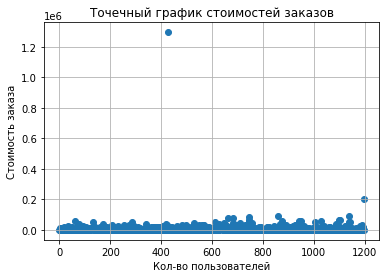

In [26]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.grid()
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа');

На графике видны два выброса (аномальных значения)

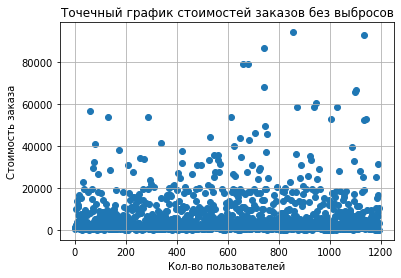

In [27]:
norm_orders = orders[orders['revenue']<=200000]['revenue']
x_values = pd.Series(range(0,len(norm_orders)))
plt.scatter(x_values, norm_orders)
plt.title('Точечный график стоимостей заказов без выбросов')
plt.grid()
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа');

###  95-й и 99-й перцентили стоимости заказов

In [28]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 28000.00
99 перцентиль: 58233.20


In [29]:
orders.query('revenue > 35000')['revenue'].count()/orders['revenue'].count()*100

3.091060985797828

Как аномальные можно отсеять заказы стоимостью выше 35000 рублей

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Нулевая гипотеза H0 - статистически значимых различий в количестве заказов между группами нет  
Альтернативная гипотеза Н1 - статистически значимые различия есть  

In [30]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
display("относительный прирост количества заказов группы B = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))
 

'alpha = 0.05'

'p-value = 0.017'

'относительный прирост количества заказов группы B = 0.138'

p-value < alpha, поэтому нулевую гипотезу отвергаем. Значит статистически значимые различия между группами А и В есть. Относительный прирост количества заказов группы B равен 14%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза H0 - статистически значимых различий в среднем чеке заказа между группами нет  
Альтернативная гипотеза Н1 - статистически значимые различия есть  

In [32]:
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display("Относительный показатель = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'alpha = 0.05'

'p-value = 0.729'

'Относительный показатель = 0.259'

p-value > alpha, поэтому нулевую гипотезу  не отвергаем. Значит статистически значимых различии между группами А и В нет. Относительный показатель, средний чек группы B выше на 26% возможно в связи с дорогим заказом

###  Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Нулевая гипотеза H0 - статистически значимых различий в количестве заказов между группами нет.  
Альтернативная гипотеза Н1 - статистически значимые различия есть 

In [33]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print("Всего аномальных пользователей =" ,abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
dtype: int64
Всего аномальных пользователей = 53


In [34]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display("относительный прирост количества заказов группы B = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

'alpha = 0.05'

'p-value = 0.010'

'относительный прирост количества заказов группы B = 0.179'

p-value < alpha, поэтому нулевую гипотезу  отвергаем. Значит статистически значимых различии между группами А и В есть. Относительный прирост количества заказов группы B равен 18% (выше, чем с 'сырыми' данными)

###  Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза H0 - статистически значимых различий в средних чеках между группами нет  
Альтернативная гипотеза Н1 - статистически значимые различия есть

In [35]:
display("alpha = 0.05")
display("p-value = {0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

display("Относительный показатель В и А = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

'alpha = 0.05'

'p-value = 0.885'

'Относительный показатель В и А = 0.022'

p-value > alpha, поэтому нулевую гипотезу не отвергаем. Значит статистически значимых различии между группами А и В нет. Относительный показатель, средний чек группы B выше на 3% (по 'сырым' данным был выше на 26%)

### Принятие решения по результатам теста

1. Есть статистически значимое различие по количеству заказов между группами как по «сырым» данным, так и по «очищенным». У группы В количество заказов выше на 18% по "очищенным" данным и на 14% по "сырым"
2. Нет статистически значимого различия по среднему чеку между группами. Исключение аномальных данных изменило значение относительного показателя среднего чека группы B (по "сырым" данным был выше на 26%, по «очищенным» - 3%)

Основываясь на результатах проведенного А/В теста, рекомендую остановить тест и зафиксировать победу группы В, но обратить внимание на увеличение среднего чека 



